# Driver of LIM using PyTorch

## Import Modules

In [12]:
# import modules
import math
import numpy as np
import os

import matplotlib as mpl
mpl.rc('image', cmap='jet')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

# from lim_mod_pt import LIM

import torch
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

## Data

In [13]:
# data
if False:
    # red noise
    from ode_AM_index_config import get_red_noise as get_data
    gamma = [0.06]
    true_t, true_y = get_data(gamma=gamma, data_size=10000)
else:
    # annular mode
    from read_AM_index_mod import get_AM_index as get_data
    t_np, y_np, p_np = get_data()

t = torch.from_numpy(t_np)
if y_np.ndim == 1:
    y = torch.from_numpy(y_np)[:,None]
else:
    y = torch.from_numpy(y_np)

print(f't.shape = {t.shape}, y.shape = {y.shape}')

# test of the method for eigen decomposition
# from lim_mod import test_eig_m
# test_eig_m(y, 5)

Reading from saved data ......
Use pressure levels = [   1.    2.    3.    5.    7.   10.   20.   30.   50.   70.  100.  125.
  150.  175.  200.  225.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  775.  800.  825.  850.  875.  900.  925.  950.  975.
 1000.]

t.shape = torch.Size([21535]), y.shape = torch.Size([21535, 37])


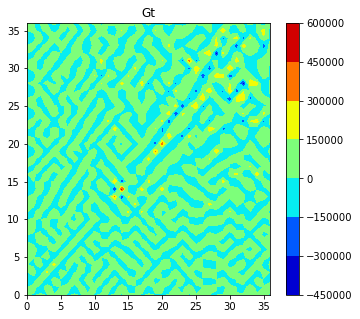

In [14]:
import torch.linalg as la

rcond=1e-10

#=============================================================
# class LIM()
# Linear Inverse Model
#=============================================================
class LIM():
    def __init__(self, X, lag, method='eig2', verbose=False):
        """
        POP analysis described in Penland (1989) 
        X(t, x): input data, where t is time, and x is space
        lag: lag time used to compute Ct

        The propagation matrix is calculated as
        `Gt = Ct @ C0_inv`.

        The eigenvector decomposition of the propagation matrix (using the function `eig_m`) is 
        `Gt @ vr = vr @ torch.diag(w)` or `Gt = vr @ torch.diag(w) @ vl.H`, \\
        where vl and vr are biorthogonal bases, `vr @ vl.H = I`, and `vl.H @ vr = I`.

        The projection of `x` in the eigenvector space is
        `pc(t, eig) = (vl.H @ X.H).H = X @ vl`, \\
        and the reconstruction in the physical space is
        `X(t, x) = (vr @ pc.H).H = pc @ vr.H`.

        method options:
        eig1: solve vl and vr simulateneously by calling `eig` in scipy
        eig2: solve vl and vr separately by calling `eig` twice
        pinv: solve vr by calling `eig`, and then solve vl by calling `pinv`
        """

        self.w, self.vl, self.vr, self.b, self.B = self.pop(X, lag, method=method, verbose=verbose)

    def pop(self, X, lag, method='eig2', verbose=False):
        data_size = len(X)
        C0 = X.T @ X / data_size
        Ct = X[lag:].T @ X[0:data_size-lag] / (data_size-lag)

        C0_inv = la.pinv(C0)    # pseudo-inverse for a singular matrix
        Gt = Ct @ C0_inv

        w, vl, vr = eig_m(Gt, method=method, verbose=verbose)
        b = torch.log(w)/lag
        B = vr @ torch.diag(b) @ vl.conj().T
        if verbose:
            print(f"POP e-folding timescales =\n {-1/b.real}")

        return w, vl, vr, b, B

    def forecast(self, X, lag):
        """
        X(batch, x): batch of initial conditions
        lag: time lags to be forecasted
        return y(lag, batch, x): batch forecasts at time lag starting from X
        """
        
        y = torch.zeros((0, *X.shape))
        for idx in range(len(lag)):
            Gt = self.vr @ torch.diag(torch.exp(self.b * lag[idx])) @ self.vl.conj().T
            Xt = (Gt @ X.T).T
            y = torch.vstack((y, Xt[None, :]))
        
        return y.real

#=============================================================
# function eig_m()
# modified version of eigenvector decomposition: ``w, vl, vr = eig_m(a)``
#=============================================================
def eig_m(a, method='eig2', verbose=False):
    """
    modified version of eigenvector decomposition:
    ``w, vl, vr = eig_m(a)``

    Factorizes the square matrix `a` into the normalized eigenvector matrix ``vr``, its inverse ``vl.H``, and
    a 1-D array ``w`` of eigenvalues: \\
    ``a @ vr = vr @ torch.diag(w)`` or ``a = vr @ torch.diag(w) @ vl.H`` \\
    where ``vl`` and ``vr`` are biorthogonal bases, `vr @ vl.H = I`, and `vl.H @ vr = I`.

    method options:
    eig1: solve vl and vr simulateneously by calling `eig` in scipy
    eig2: solve vl and vr separately by calling `eig` twice
    pinv: solve vr by calling `eig`, and then solve vl by calling `pinv`
    """

    # function to sort eigenvectors v by the decending order of eigenvalues w, with the option to sort by w.congj()
    def eig_sort(w, v, sort_by_w=True):
        w_np = w.numpy()
        if sort_by_w:
            idx_w_sort_np = w_np.argsort()[::-1]
        else:
            idx_w_sort_np = w_np.conj().argsort()[::-1]    # sort by w.conj()
        idx_w_sort = torch.from_numpy(idx_w_sort_np.copy())

        w_sort = torch.zeros_like(w)
        v_sort = torch.zeros_like(v)
        for idx, idx_sort in enumerate(idx_w_sort):
            w_sort[idx] = w[idx_sort]
            v_sort[:, idx] = v[:, idx_sort]

        return w_sort, v_sort

    # perform eigendecomposition
    if method == 'eig1':
        w1, vl1, vr1 = la.eig(a, left=True)
        w, vr = eig_sort(w1, vr1)
        _, vl = eig_sort(w1, vl1)
    
    elif method == 'eig2':
        w1, vr1 = la.eig(a)
        w, vr = eig_sort(w1, vr1)

        w2, vl2 = la.eig(a.conj().T)
        _, vl = eig_sort(w2, vl2, sort_by_w=False)
    
    elif method == 'pinv':
        w1, vr1 = la.eig(a)
        w, vr = eig_sort(w1, vr1)

        vl = la.pinv(vr).conj().T
    
    else:
        raise Exception('The method for eigenvector decomposition is not specified!')

    # form a biorthogonal system
    # note the transpose operator (.T) in python differs from the operator (') in matlab for a complex
    vlH_vr = vl.conj().T @ vr
    for idx in range(len(w)):
        vl[:, idx] = vl[:, idx]/(vlH_vr[idx, idx].conj())

    if verbose:
        # To ensure the biorthogonality, vr is normalized, but vl is not normalized in the modified version 
        vrH_vr = vr.conj().T @ vr
        print(f"diagonal(vrH_vr)=\n{torch.diagonal(vrH_vr).real}")

        vlH_c = vl.conj().T @ vr @ vl.conj().T
        print(f"norm(vlH - vlH @ vr @vlH) = {la.norm(vl.conj().T-vlH_c)}")

        vr_c = vr @ vl.conj().T @ vr
        print(f"norm(vr - vr @ vlH @vr) = {la.norm(vr-vr_c)}")

        a_c = vr @ torch.diag(w) @ vl.conj().T
        print(f"norm(a - vr @ diag(w) @vlH) = {la.norm(a-a_c)}")

        fig = plt.figure(figsize=(12,5))
        ax = fig.add_subplot(1, 2, 1)
        plt.contourf(a, cmap='jet')
        plt.title('a')
        plt.colorbar()

        ax = fig.add_subplot(1, 2, 2)
        plt.contourf((a-a_c).real, cmap='jet')
        plt.title('a - vr @ diag(w) @vlH')
        plt.colorbar()
        
    return w, vl, vr

def cal_Gt(X, lag, verbose=False):
        data_size = len(X)
        C0 = X.T @ X / data_size
        Ct = X[lag:].T @ X[0:data_size-lag] / (data_size-lag)

        C0_inv = la.pinv(C0, rcond=rcond)    # pseudo-inverse for a singular matrix
        Gt = Ct @ C0_inv

        fig = plt.figure(figsize=(12,5))
        ax = fig.add_subplot(1, 2, 1)
        plt.contourf(C0_inv, cmap='jet')
        plt.title('Gt')
        plt.colorbar()
        return Gt

def test_eig_m(X, lag):
        Gt = cal_Gt(X, lag) 
        # w1, vl1, vr1 = eig_m(Gt, method='eig1', verbose=True) # not available in PyTorch
        w2, vl2, vr2 = eig_m(Gt, method='eig2', verbose=True)
        w3, vl3, vr3 = eig_m(Gt, method='pinv', verbose=True)

# test_eig_m(y, 5)
Gt = cal_Gt(y, 5, verbose=True)

## Model

In [ ]:
lag = 5
model = LIM(y, lag=lag, method='eig2', verbose=True)

lag_time = 90
yf = model.forecast(y[:-lag_time], t[:lag_time+1])
print(f"\ny(t, x) = {y.shape}")
print(f"yf(lag, batch, x) = {yf.shape}")

## Plot the linear operator 

In [ ]:
val_time = 30
Ct = y[val_time:].T @ y[:-val_time] / (len(y)-val_time)
Ctf = yf[val_time,:,:].T @ yf[0,:,:] / yf.shape[1]
print(f"Ct = {Ct.shape}")
print(f"Ctf = {Ctf.shape}")

fig = plt.figure(figsize=(12,10))
cmax = 1
ax = fig.add_subplot(3,2,1)
plt.contourf(model.B.real, np.linspace(-cmax, cmax, 21))
plt.title('B (real)')
plt.colorbar()

ax = fig.add_subplot(3,2,2)
plt.contourf(model.B.imag)
plt.title('B (imag)')
plt.colorbar()

ax = fig.add_subplot(3,2,3)
plt.plot(model.vr.real[:,:2])
plt.title('vr')

ax = fig.add_subplot(3,2,4)
plt.plot(model.vl.real[:,:2])
plt.title('vl')

cmax = 0.5
ax = fig.add_subplot(3,2,5)
plt.contourf(Ct, np.linspace(-cmax, cmax, 21))
plt.title('Cov')
plt.colorbar()

ax = fig.add_subplot(3,2,6)
plt.contourf(Ctf, np.linspace(-cmax, cmax, 21))
plt.title('Cov (forecast)')
plt.colorbar()

## Plot autocovariance

In [ ]:
from plot_AM_index_mod import plot_cov

k = np.isin(p, 10).nonzero()[0][0]
plot_cov(y, yf=yf, k=k, lag_time=lag_time)


## Plot lagged covariance

In [ ]:
from plot_AM_index_mod import plot_lag_reg

plot_lag_reg(y, p, yf)

## Make composite for strong and weak vortex events


In [ ]:
from plot_AM_index_mod import plot_event

plot_event(y, p, yf=yf, lag_time=lag_time)